# Generative Adversarial Network

#Importing required libraries

In [ ]:
from keras.models import load_model
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import ZeroPadding2D, Conv2D, BatchNormalization, Dense, Reshape, Conv2DTranspose, Flatten, Activation, Input
from keras.activations import relu
from keras.models import Model
from keras.layers import Input
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import ZeroPadding2D, Conv2D, BatchNormalization, Dense, Reshape, Conv2DTranspose, Flatten, Activation, Input
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from keras.layers import LeakyReLU
 
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

Using TensorFlow backend.


#Mounting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Part 1: Implement the Discriminator of the DCGAN

In [ ]:
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	model.add(Conv2D(32,(5,5), input_shape = (32,32,3),padding='same'))
	model.add(BatchNormalization(momentum=0.8))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(32,(5,5),strides=(2, 2),padding='same'))
	model.add(BatchNormalization(momentum=0.8))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(64,(5,5),strides=(2, 2),padding='same'))
	model.add(BatchNormalization(momentum=0.8))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128,(5,5),strides=(2, 2),padding='same'))
	model.add(BatchNormalization(momentum=0.8))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	opt = Adam(lr=2e-4, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	model.summary()
	return model

#Part 2: Implement the Generator

In [ ]:
# define the standalone generator model
def define_generator(latent_dim=100):
	model = Sequential()
	model.add(Dense(128*4*4, input_dim = latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4,4,128)))
	#model.add(BatchNormalization())
	model.add(Conv2DTranspose(64, (5,5), strides = (2,2),padding= 'same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(BatchNormalization())
	model.add(Conv2DTranspose(32, (5,5), strides = (2,2),padding= 'same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(BatchNormalization())
	model.add(Conv2DTranspose(32, (5,5), strides = (2,2),padding= 'same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model
 
def define_gan(g_model, d_model):
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = Adam(lr=2e-4, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

#Part 3: Training the model


In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs+1):
		
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			x_input = randn(latent_dim * n_batch)
			X_gan = x_input.reshape(n_batch, latent_dim)
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
		print('epoch: %d, discriminator_loss = %.3f GAN_loss = %.3f' %(i+1,d_loss2, g_loss))
		img = X_fake
		if (i+1)%5 == 0:
			img = (img + 1) / 2.0
			for k in range(5):
				pyplot.subplot(1, 5, 1 + k)
				pyplot.axis('off')
				pyplot.imshow(img[k])


 
def save_model(model, fn):
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  model.save(fn)
  model_file = drive.CreateFile({'title' : fn})
  model_file.SetContentFile(fn)
  model_file.Upload()
  drive.CreateFile({'id': model_file.get('id')})
 

 

def generate_real_samples(dataset, n_samples):
	
	ix = randint(0, dataset.shape[0], n_samples)

	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y
 
def generate_fake_samples(g_model, latent_dim, n_samples):

	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)

	X = g_model.predict(x_input)
	y = zeros((n_samples, 1))
	return X, y
 

def save_plot(examples, epoch, n=5):
	examples = (examples + 1) / 2.0
	for i in range(n):
		pyplot.subplot(1, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i])
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
  
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
(x_train, _), (_, _) = load_data()
x_train2 = x_train.astype("float32")
x_train2 = (x_train2 - 127.5)/127.5
dataset = x_train2
train(g_model, d_model, gan_model, dataset, latent_dim)

### Part 4: Experiment





In [ ]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import np_utils
%tensorflow_version 1.x

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
import tqdm
from collections import defaultdict
from keras.models import save_model
NUM_CLASSES = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# normalize inputs
x_train2 = (x_train/255) - 0.5
x_test2 = (x_test/255) - 0.5

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test2 = tf.keras.utils.to_categorical(y_test, num_classes=10)

def make_model():
  model = Sequential()
  model.add(Conv2D(16,(3,3),strides=(1, 1), input_shape=(32, 32, 3), padding="same"))
  model.add(LeakyReLU(0.1))
  model.add(Conv2D(32,(3,3),strides=(1, 1), input_shape=(32, 32, 3), padding="same"))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(32,(3,3),strides=(1, 1), input_shape=(32, 32, 3), padding="same"))
  model.add(LeakyReLU(0.1))
  model.add(Conv2D(64,(3,3),strides=(1, 1), input_shape=(32, 32, 3), padding="same"))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.5))
  model.add(Dense(NUM_CLASSES))  
  model.add(Activation("softmax"))

  return model

  

class TqdmProgressCallback(keras.callbacks.Callback):

    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']

    def on_epoch_begin(self, epoch, logs=None):
        print('Epoch %d/%d' % (epoch + 1, self.epochs))
        if "steps" in self.params:
            self.use_steps = True
            self.target = self.params['steps']
        else:
            self.use_steps = False
            self.target = self.params['samples']
        self.prog_bar = tqdm.tqdm_notebook(total=self.target)
        self.log_values_by_metric = defaultdict(list)

    def _set_prog_bar_desc(self, logs):
        for k in self.params['metrics']:
            if k in logs:
                self.log_values_by_metric[k].append(logs[k])
        desc = "; ".join("{0}: {1:.4f}".format(k, np.mean(values)) for k, values in self.log_values_by_metric.items())
        if hasattr(self.prog_bar, "set_description_str"):  # for new tqdm versions
            self.prog_bar.set_description_str(desc)
        else:
            self.prog_bar.set_description(desc)

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        if self.use_steps:
            self.prog_bar.update(1)
        else:
            batch_size = logs.get('size', 0)
            self.prog_bar.update(batch_size)
        self._set_prog_bar_desc(logs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self._set_prog_bar_desc(logs)
        self.prog_bar.update(1)  # workaround to show description
        self.prog_bar.close()


class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
def save_model(model, fn):
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  model.save(fn)
  model_file = drive.CreateFile({'title' : fn})
  model_file.SetContentFile(fn)
  model_file.Upload()
  drive.CreateFile({'id': model_file.get('id')})

def train_mod(model, x_train2, y_train2,filename):
  INIT_LR = 5e-3  # initial learning rate
  BATCH_SIZE = 32
  EPOCHS = 10



  # prepare model for fitting (loss, optimizer, etc)
  model.compile(
      loss='categorical_crossentropy',  # we train 10-way classification
      optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
      metrics=['accuracy']  # report accuracy during training
  )
  def lr_scheduler(epoch):
      return INIT_LR * 0.9 ** epoch

  # callback for printing of actual learning rate used by optimizer
  class LrHistory(keras.callbacks.Callback):
      def on_epoch_begin(self, epoch, logs={}):
          print("Learning rate:", K.get_value(model.optimizer.lr))
          
  # we will save model checkpoints to continue training in case of kernel death
  model_filename = 'cifar.{0:03d}.hdf5'
  last_finished_epoch = None

  # fit model
  model.fit(
      x_train2, y_train2,  # prepared data
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
                LrHistory(), 
                TqdmProgressCallback(),
                ModelSaveCallback(model_filename)],
      shuffle=True,
      verbose=1,
      initial_epoch=last_finished_epoch or 0
  )

  # save weights to file
  save_model(model,filename)

TensorFlow is already loaded. Please restart the runtime to change versions.


Training the classifier on the original CIFAR-10 images. 


In [ ]:
model = make_model()
train_mod(model, x_train2, y_train2, "first.h5")

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
Learning rate: 0.005
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


50000/50000 [==============================] - 13s 263us/step - loss: 1.3952 - accuracy: 0.5001 - val_loss: 1.0232 - val_accuracy: 0.6326

Model saved in cifar.000.hdf5
Epoch 2/10
Learning rate: 0.0045
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


50000/50000 [==============================] - 12s 249us/step - loss: 0.9813 - accuracy: 0.6547 - val_loss: 0.8834 - val_accuracy: 0.6934

Model saved in cifar.001.hdf5
Epoch 3/10
Learning rate: 0.00405
Epoch 3/10


50000/50000 [==============================] - 13s 253us/step - loss: 0.8408 - accuracy: 0.7057 - val_loss: 0.7623 - val_accuracy: 0.7376

Model saved in cifar.002.hdf5
Epoch 4/10
Learning rate: 0.003645
Epoch 4/10


50000/50000 [==============================] - 13s 259us/step - loss: 0.7506 - accuracy: 0.7381 - val_loss: 0.6965 - val_accuracy: 0.7576

Model saved in cifar.003.hdf5
Epoch 5/10
Learning rate: 0.0032805
Epoch 5/10


50000/50000 [==============================] - 12s 250us/step - loss: 0.6843 - accuracy: 0.7596 - val_loss: 0.6786 - val_accuracy: 0.7684

Model saved in cifar.004.hdf5
Epoch 6/10
Learning rate: 0.00295245
Epoch 6/10


50000/50000 [==============================] - 12s 247us/step - loss: 0.6301 - accuracy: 0.7796 - val_loss: 0.6965 - val_accuracy: 0.7637

Model saved in cifar.005.hdf5
Epoch 7/10
Learning rate: 0.002657205
Epoch 7/10


50000/50000 [==============================] - 12s 248us/step - loss: 0.5888 - accuracy: 0.7925 - val_loss: 0.6226 - val_accuracy: 0.7924

Model saved in cifar.006.hdf5
Epoch 8/10
Learning rate: 0.0023914846
Epoch 8/10


50000/50000 [==============================] - 12s 247us/step - loss: 0.5480 - accuracy: 0.8074 - val_loss: 0.6297 - val_accuracy: 0.7914

Model saved in cifar.007.hdf5
Epoch 9/10
Learning rate: 0.002152336
Epoch 9/10


50000/50000 [==============================] - 12s 250us/step - loss: 0.5207 - accuracy: 0.8177 - val_loss: 0.6025 - val_accuracy: 0.7946

Model saved in cifar.008.hdf5
Epoch 10/10
Learning rate: 0.0019371024
Epoch 10/10


50000/50000 [==============================] - 12s 249us/step - loss: 0.4955 - accuracy: 0.8249 - val_loss: 0.6247 - val_accuracy: 0.7971

Model saved in cifar.009.hdf5


Generating fake images for the CIFAR-10 dataset using the previously trainded GAN.  

In [ ]:
from keras.models import load_model
g_mod = load_model('/content/generator_model_200.h5')
lat = tf.random.normal(shape=(25000, 100))
gen_images = g_mod(lat)
out = K.eval(gen_images)
lat = tf.random.normal(shape=(25000, 100))
gen_images = g_mod(lat)
out2 = K.eval(gen_images)
out = np.concatenate((out,out2))
out_test = out
out = (out +1)/2

Using the train classifier(c) to predict the class for the generated fake images.


In [ ]:
model = load_model('/content/first.h5')
y = model.predict(out)
y_class = np.argmax(y, axis=1)
print(y_class[0])
print(y_train2.shape)
#out = (out/255) - 0.5
y_class = tf.keras.utils.to_categorical(y_class, num_classes=10)

8
(50000, 10)
[[[[0.6425967  0.5834889  0.46006972]
   [0.6172129  0.5999725  0.45711055]
   [0.6235053  0.60382366 0.48258445]
   ...
   [0.589378   0.41188085 0.43067312]
   [0.5844206  0.4124361  0.41866356]
   [0.5754433  0.42066324 0.40265226]]

  [[0.64326394 0.59714866 0.49796233]
   [0.61112225 0.5947682  0.49302748]
   [0.61458915 0.60029626 0.5060967 ]
   ...
   [0.5662086  0.41694635 0.42763186]
   [0.5810665  0.40664715 0.411299  ]
   [0.58229893 0.39870533 0.39633045]]

  [[0.65230954 0.61776984 0.51411664]
   [0.62475836 0.60671866 0.49871767]
   [0.6442962  0.60180604 0.5047652 ]
   ...
   [0.55633074 0.4124415  0.40516526]
   [0.57844055 0.4068297  0.40323946]
   [0.58620703 0.39320853 0.39344373]]

  ...

  [[0.79800653 0.5590006  0.2254686 ]
   [0.805266   0.63875794 0.21582243]
   [0.8205185  0.6507081  0.23190862]
   ...
   [0.82648504 0.29557753 0.19285387]
   [0.8016939  0.3228878  0.21410584]
   [0.7861765  0.32848844 0.23624551]]

  [[0.76799387 0.5695175  0.245

Training a classifier(c') on the generated fake images with the labels predicted by the classifier(c).

In [ ]:
model2 = make_model()
train_mod(model2, out, y_class, "second.h5")

Epoch 1/10
Learning rate: 0.005
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


50000/50000 [==============================] - 12s 233us/step - loss: 1.1546 - accuracy: 0.5813

Model saved in cifar.000.hdf5
Epoch 2/10
Learning rate: 0.0045
Epoch 2/10


50000/50000 [==============================] - 11s 223us/step - loss: 0.8796 - accuracy: 0.6731

Model saved in cifar.001.hdf5
Epoch 3/10
Learning rate: 0.00405
Epoch 3/10


50000/50000 [==============================] - 11s 215us/step - loss: 0.7858 - accuracy: 0.7055

Model saved in cifar.002.hdf5
Epoch 4/10
Learning rate: 0.003645
Epoch 4/10


50000/50000 [==============================] - 11s 219us/step - loss: 0.7205 - accuracy: 0.7287

Model saved in cifar.003.hdf5
Epoch 5/10
Learning rate: 0.0032805
Epoch 5/10


50000/50000 [==============================] - 11s 221us/step - loss: 0.6723 - accuracy: 0.7455

Model saved in cifar.004.hdf5
Epoch 6/10
Learning rate: 0.00295245
Epoch 6/10


50000/50000 [==============================] - 11s 223us/step - loss: 0.6353 - accuracy: 0.7573

Model saved in cifar.005.hdf5
Epoch 7/10
Learning rate: 0.002657205
Epoch 7/10


50000/50000 [==============================] - 11s 221us/step - loss: 0.5992 - accuracy: 0.7721

Model saved in cifar.006.hdf5
Epoch 8/10
Learning rate: 0.0023914846
Epoch 8/10


50000/50000 [==============================] - 11s 214us/step - loss: 0.5695 - accuracy: 0.7816

Model saved in cifar.007.hdf5
Epoch 9/10
Learning rate: 0.002152336
Epoch 9/10


50000/50000 [==============================] - 11s 215us/step - loss: 0.5418 - accuracy: 0.7932

Model saved in cifar.008.hdf5
Epoch 10/10
Learning rate: 0.0019371024
Epoch 10/10


28736/50000 [================>.............] - ETA: 4s - loss: 0.5168 - accuracy: 0.8014

Evaluation code.

In [ ]:
# load weights from file (can call without model.fit)
def eval_train(model, filename):
  
  cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]
  model.load_weights(filename)

  # make test predictions
  y_pred_test = model.predict_proba(x_test2)
  y_pred_test_classes = np.argmax(y_pred_test, axis=1)
  y_pred_test_max_probas = np.max(y_pred_test, axis=1)

  # inspect preditions
  cols = 8
  rows = 2
  count = 0
  fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
  for i in range(cols):
      for j in range(rows):
          random_index = count
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)
          ax.grid(b=False)
          ax.axis(b=False)
          ax.imshow(x_test[random_index, :])
          pred_label = cifar10_classes[y_pred_test_classes[random_index]]
          pred_proba = y_pred_test_max_probas[random_index]
          true_label = cifar10_classes[y_test[random_index, 0]]
          count = count+1
          ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
                pred_label, pred_proba, true_label
          ))
  plt.show()

Evaluating the classifier(c) trained on original images.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


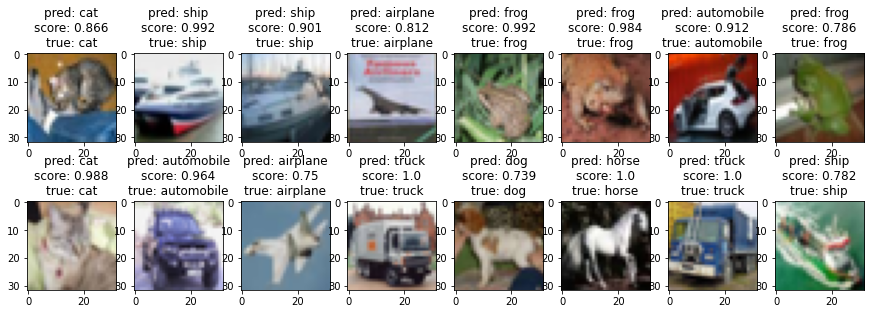

In [ ]:
eval_train(model,"/content/first.h5")

Evaluating classifier(c') trained on fake images.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


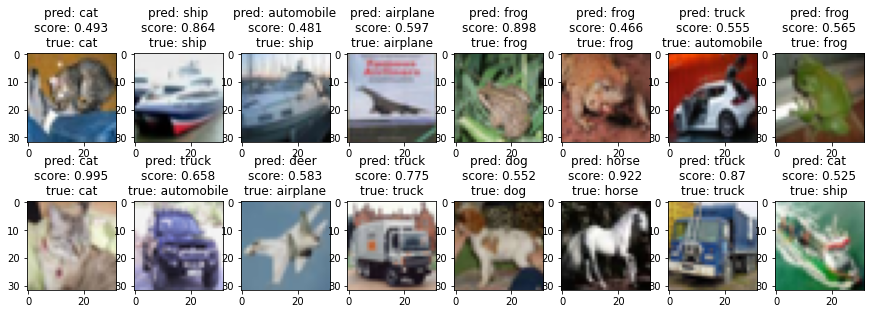

In [ ]:
eval_train(model2,"/content/second.h5")